# A first look at the business cycle using principal component analysis

What do we mean with _the_ business cycle? Good times and bad times, boom and bust, expansion and recession. The economics lingo makes it sound as if the state of the economy is more or less moving in a one-dimensional space. As it turns out, this is true to a surprisingly high degree. In this note, I want to use the tool of _principal component analysis_ to introduce you to this fact. 

The idea of this teaching note is to do a relatively atheoretical analysis of the data, in such a way that we can retrace the steps through which earlier economists (e.g., [Burns and Mitchell 1946](https://www.nber.org/books-and-chapters/measuring-business-cycles)) "discovered" the business cycle. The intended audience is MSc students in economics at the University of Oslo as well as anyone else with a somewhat quantitative background (e.g., engineers).

The note proceeds as follows:
We download data on macroeconomic variables and indicators from FRED.
We then apply principal component analysis to this data and learn that the first principal component accounts for a large share of the variation in the data. In particular, real variables (quantities) comove very closely with the first principal component.

All analysis is conducted using Python.

The fact that this first principal component accounts for such a large share of the data motivates why commentators speak of "the business cycle". The business cycle is simply the first principal component.

## Downloading macroeconomic data from FRED

[FRED](https://fred.stlouisfed.org) is an excellent source for macroeconomic data, especially for the US. Below, I download twelve macroeconomic time series from FRED.

These are real GDP, real personal consumption expenditure, real private investment, unemployment, hours worked per person in manufacturing, real government consumption, a measure of "sentiment" from a household survey, the federal funds rate, the M2 money stock, the price level (CPI), a stock market index, and a house price index.

In [29]:
from fredapi import Fred
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

variables = ['GDPCA', 'PCECCA','GPDICA', 'UNRATE', 'AWHMAN',
             'GCECA','FEDFUNDS', 'M2SL', 'CPIAUCSL', 
             'NASDAQCOM', 'USSTHPI', 'UMCSENT']
variables_labels = ['Real GDP', 
                    'Real Personal Consumption',
                    'Real Private Investment', 
                    'Unemployment',
                    'Hours worked (manufacturing)', 
                    'Real Government Consumption',
                    'Federal funds rate', 
                    'Money stock',
                    'CPI', 
                    'Stock market',
                    'House prices', 
                    'Sentiment']
#If you want to download data from FRED, 
#you have to get a free API key and
#input it here

fred = Fred(api_key = 'ec078ae1fd3f68ba401d248debab3865')
def pull_annual_log_growth(text):
  return np.log(fred.get_series(text).resample('YE').mean()).diff()
df = pd.DataFrame([pull_annual_log_growth(var) 
                  for var in variables]).transpose()
df.columns = variables
df = df.dropna(axis=0)

I will not go through in detail the definition of these variables and how they were constructed. If you go to [https://fred.stlouisfed.org/series/GDPCA](https://fred.stlouisfed.org/series/GDPCA), you will find information about real GDP. Replace GDPCA by PCECCA and you will find information about real personal consumption, etc.

__Suggested optional homework:__ Read through the description of at least one of these variables. Click around the FRED homepage and look at some of the other variables that I did not include.

Below, I load these variables and compute the annual log growth in the variables. __Our dataset that we will subject to principal component analysis, "df", consists of the annual log growth rates for the variables.__ We print a few observations for a few variables.

In [30]:
df[['GDPCA', 'PCECCA', 'GPDICA', 
    'UNRATE', 'AWHMAN', 'GCECA']].head()

,GDPCA,PCECCA,GPDICA,UNRATE,AWHMAN,GCECA
1976-12-31,0.052479,0.054236,0.174661,-0.095900,0.018226,0.005196
1977-12-31,0.045205,0.041396,0.133362,-0.088193,0.004763,0.011976
1978-12-31,0.053874,0.042834,0.109459,-0.150218,0.001033,0.028272
1979-12-31,0.031169,0.023492,0.034449,-0.036368,-0.005173,0.017835
1980-12-31,-0.002571,-0.003127,-0.106048,0.204161,-0.011896,0.017938


## Principal component analysis

Each yearly observation (e.g., 1976) consists of twelve numbers, one for each variable. We can thus view each yearly observation as lying in a twelve-dimensional vector space. We have a total of 47 observations so the entire data set consists of 47 vectors in a twelve-dimensional space. Although the vectors almost definitely span the entire twelve-dimensional space, one may wonder if they "mostly" lie in a lower-dimensional subspace.
[Principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) is a way to answer this question.

For each line (one-dimensional subspace), one can compute the distance between our observations and the line. The first principal component is the line such that the sum of the squared distance between our observations and the line is minimized. In the extreme case that the distance between all the observations and the line is zero, the observations lie on the line and our observations literally reside in a one-dimensional subspace. If the sum of the squared distance is small, they "mostly" lie in a one-dimensional subspace.

Below, we compute the first principal component. 

One technical detail: before we perform the principal component analysis, we rescale and shift all the variables so that they have mean zero and unit variance (this is what the "StandardScaler" does in the code). This ensures that each variable is given equal weight in the analysis and that we can assume that the best line goes through the origin (i.e., is a subspace of the vector space).

One etymology detail: "principal" means "first", so the "first principal component" really is the "first first component". The purist in me hates it, but "first principal component" is common usage so I will stick with it...

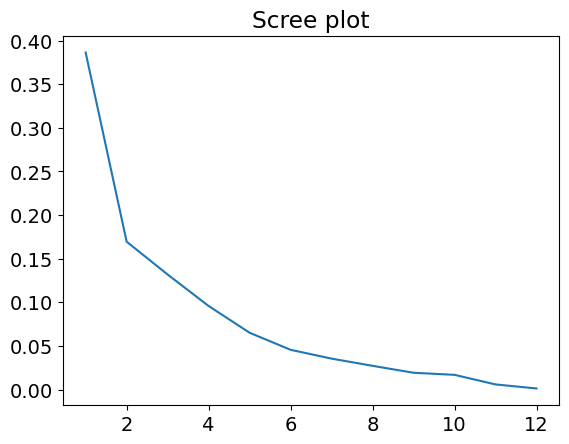

In [31]:
df_scaled = StandardScaler().fit_transform(df)
pca = PCA()
pca.fit(df_scaled)

plt.plot(np.arange(1, len(pca.explained_variance_ratio_)+1),
pca.explained_variance_ratio_)
plt.title('Scree plot')
plt.savefig('scree.pdf')
factors = pca.fit_transform(df_scaled)
df['pc1'] = factors[:,0]
components1 = pd.DataFrame(pca.components_[0,:]).transpose()
components1.columns = variables

The [scree plot](https://en.wikipedia.org/wiki/Scree_plot) shows that 40% of the variation in the data is accounted for by the first principal component, 17% by the second, and so on.

### The first principal component and real variables

Below, we plot the real variables together with the projection of the variables onto the first principal component.

Technical detail: since we shifted and scaled the variables prior to the PCA, we shift and scale the principal component.

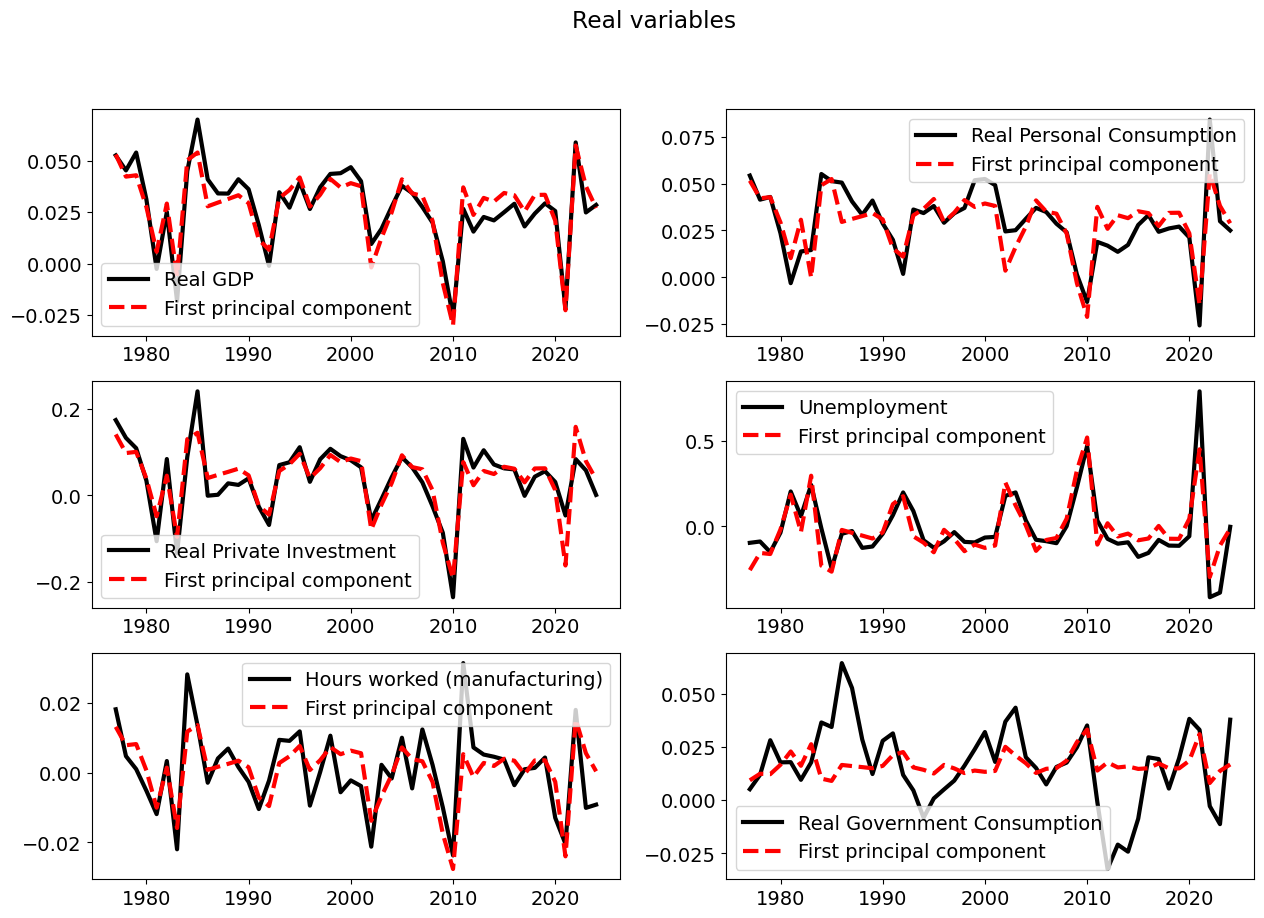

In [32]:
plt.figure(figsize=(15,10))
for k in range(6):
    var = variables[k]
    plt.subplot(3, 2, k+1)
    plt.plot(df[var], color = 'k', label = variables_labels[k], lw = 3)
    plt.plot(df[var].mean() + df[var].std()*components1[var].values*df['pc1'],
    '--', color = 'r', label = 'First principal component', lw = 3)
    plt.legend()
plt.suptitle('Real variables')
plt.savefig('real_variables.pdf')
plt.show()

The first principal component tracks all variables, except government consumption, extremely well. The fact that the first five variables move in tandem is the empirical fact behind economists speaking of _the_ business cycle. A natural first goal of business-cycle research is to provide an account of _why_ they move in tandem to the extent that they do.

The first principal component does not account as well for money, interest rates, prices and sentiment variables. We show this below.

### The first principal component and money, prices, sentiment

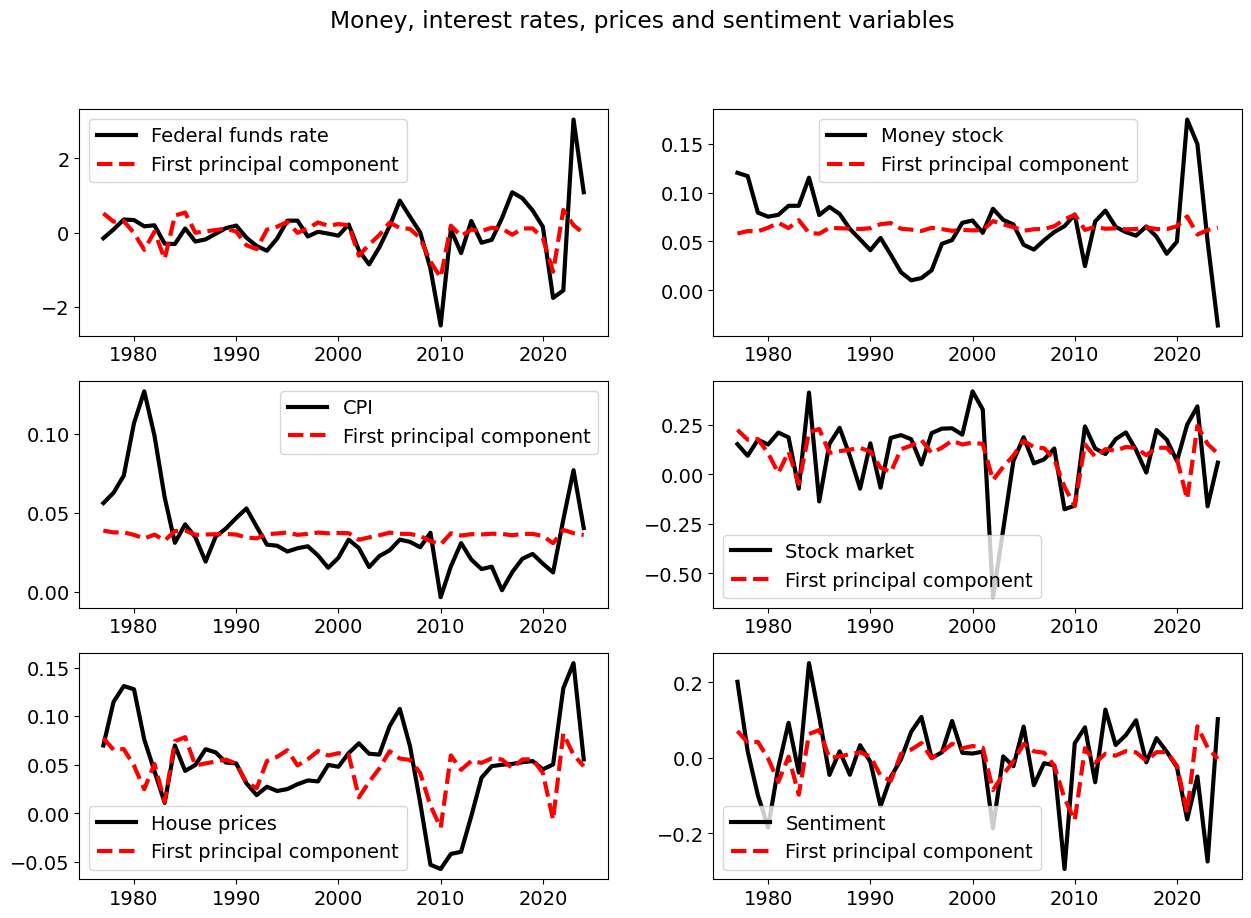

In [33]:
plt.figure(figsize=(15,10))
for k in range(6,12):
    var = variables[k]
    plt.subplot(3, 2, k-5)
    plt.plot(df[var], color = 'k', label = variables_labels[k], lw = 3)
    plt.plot(df[var].mean() + df[var].std()*components1[var].values*df['pc1'],
             '--', color = 'r', label = 'First principal component', lw = 3)
    plt.legend()
plt.suptitle('Money, interest rates, prices and sentiment variables')
plt.savefig('money_interest_prices_sentiment.pdf')
plt.show()

In particular, the first principal component is practically orthogonal to CPI.

## The first principal component and NBER recessions

We load the (annual) NBER recession dates and compare them to the time series for the first principal component.

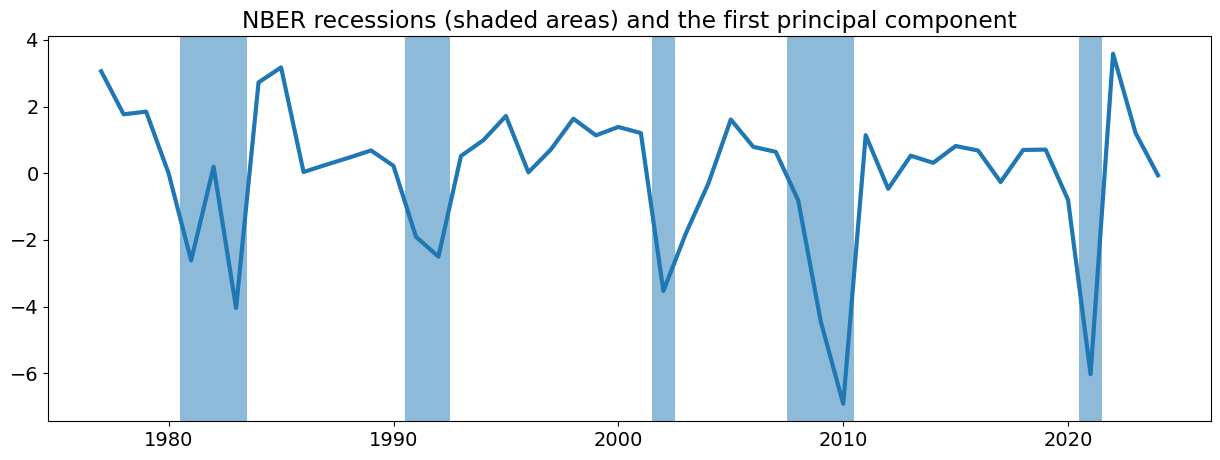

In [34]:
recessions = pd.DataFrame([[1980, 1983], [1990, 1992],
                          [2001, 2002], [2007, 2010],
                          [2020, 2021]])

recessions.columns = ['start', 'end']
recessions['start'] = pd.to_datetime(recessions['start'], format='%Y')
recessions['end'] = pd.to_datetime(recessions['end'], format='%Y')
from dateutil.relativedelta import relativedelta
plt.figure(figsize=(15,5))
for k in range(recessions.shape[0]):
    plt.axvspan(recessions.iloc[k]['start']+ pd.DateOffset(months=6),
                recessions.iloc[k]['end']+ pd.DateOffset(months=6), alpha = 0.5)
plt.plot(df.index, df['pc1'], lw = 3)
plt.title('NBER recessions (shaded areas) and the first principal component')
plt.savefig('nber_recessions.pdf')
plt.show()


The first principal component tracks the NBER recessions very well. Or, perhaps more accurately, the NBER recession dating committee succesfully manages to track the first principal component well.

A reasonable data-driven _definition_ of the business cycle is the dynamics of the first principal component. What this last figure shows is that the NBER committee agrees with this simple data-driven definition.

## Some final remarks

Through the lens of principal component analysis, it is warranted to speak of _the_ business cycle. What is more questionable is the usage of _cycle_. Did we see a sinusoidal curve in the data?

Since [(our local hero) Ragnar Frisch](https://www.sv.uio.no/econ/om/tall-og-fakta/nobelprisvinnere/ragnar-frisch/), the predominant paradigm in macroeconomics is to view the business "cycle" movements as driven by stochastic shocks ("disturbances"). These shocks give rise to interesting dynamics but, in general, not to cycles per se.